## Analysis - Part II

**In Python**

In Analysis Part I, we used R to decompose each dataset variable into their respective seasonal patterns, trend lines, and random effects. 

In this notebook we will perform stationarity tests on our dependent variable to check that it does, in fact, follow a stationary seasonal pattern and can be modeled with autocorrelation. Afterwards, we will perform tests to determine the dependent variable's lag time, then use that lag time to create an autocorrelation model.

In [21]:
import pandas as pd
import statsmodels as sm
from datetime import datetime
import seaborn as sns
import plotly.express as px
import numpy as np
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [22]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [23]:
df = pd.read_csv('dataset.csv')

In [24]:
df.head()

,Date,ED_visits,google_cough,reported_cases,google_cold,AQI
0,2012-01-01,258,35,6609,39,40.580645
1,2012-02-01,472,35,7066,27,40.793103
2,2012-03-01,457,34,9728,29,42.580645
3,2012-04-01,270,34,4698,33,45.566667
4,2012-05-01,216,31,3449,17,59.774194


In [25]:
# specifying datetime type
df['Date'] = pd.to_datetime(df['Date'])

In [26]:
px.line(df['reported_cases']) 

Influenza-Like Illness (ILI) seems to follow a seasonal trend. The trend was disrupted by the COVID-19 pandemic - flue incidence may have dropped due to masking and social distancing. Moreover, flu may have been underreported during this time due to fears folks had about visiting the doctor when sick. 

These low values wil skew our analysis, so let's drop them and focus on ILI incidence from 2012 through the end of 2019.

In [27]:
df_before_2020 = df.loc[df['Date']<datetime(year=2020, month=1, day=1)]

In [28]:
px.line(x=df_before_2020['Date'], y=df_before_2020['reported_cases']) 

This looks much better.

---

Next we will test for variable stationarity. An augmented Dicky-Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. If the null hypothesis is rejected, we may assume that the variable is stationary, or, its joint probability distribution does not change when shifted in time. If you draw a line through the middle of a stationary process, the line will be flat. There may be seasonal peaks and valleys around the trend line, but it does not trend up nor down overall.

The ADF test statistic is a negative number. The more negative the number, the stronger the rejection of the null hypothesis at a specific level of confidence.

In [29]:
cases = df_before_2020.set_index('Date')['reported_cases'].values

In [30]:
# testing for stationarity

t_stat, p_value, lags, _, critical_values, _ = adfuller(
    cases,
    autolag='AIC'
)

print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
print(f'lags: {lags}')
for key, value in critical_values.items():
    print('Critial Values:')
    print(f'   {key}, {value:.2f}')


ADF Statistic: -2.37
p-value: 0.15
lags: 12
Critial Values:
   1%, -3.51
Critial Values:
   5%, -2.90
Critial Values:
   10%, -2.59


With p-value = 0.15, we fail to reject the null hypothesis. Our test chose 12 months as the best lag, so we could infer that ILI incidence changes from year to year, which causes our data to be non-stationary. This seems like a problem, right?

Well, perhaps not. What if instead of looking at the absolute ILI incidence value in each month, we instead assess the differences in each month compared to the month prior? 

In [31]:
def difference(dataset, n):
    # this function intakes a list of values, 
    # subtracts the nth prior value,
    # and returns the list of differenced values.
    return pd.Series([dataset[i] - dataset[i - n] for i in range(1, len(dataset))])

In [32]:
# testing for stationarity

t_stat, p_value, lags, _, critical_values, _ = adfuller(
    difference(cases,1),
    autolag='AIC'
)

print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
print(f'lags: {lags}')
for key, value in critical_values.items():
    print('Critial Values:')
    print(f'   {key}, {value:.2f}')


ADF Statistic: -5.04
p-value: 0.00
lags: 11
Critial Values:
   1%, -3.51
Critial Values:
   5%, -2.90
Critial Values:
   10%, -2.59


This looks better! We reject the null and say that the differences between each month's ILI incidence and the incidence in the month prior form a stationary time series that may be modeled with autoregression.

---

In our ADF test we told the algorithm to choose the number of months to include as the lagged value based on the resulting AIC. It is not surprising that the algorithm chose lag = 12. For instance, if we want to guess how much flu there will be in August, 2024, what would be the best predictor? Well, probably August, 2023.

We can see this relationship when we look at the series' correlogram.

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

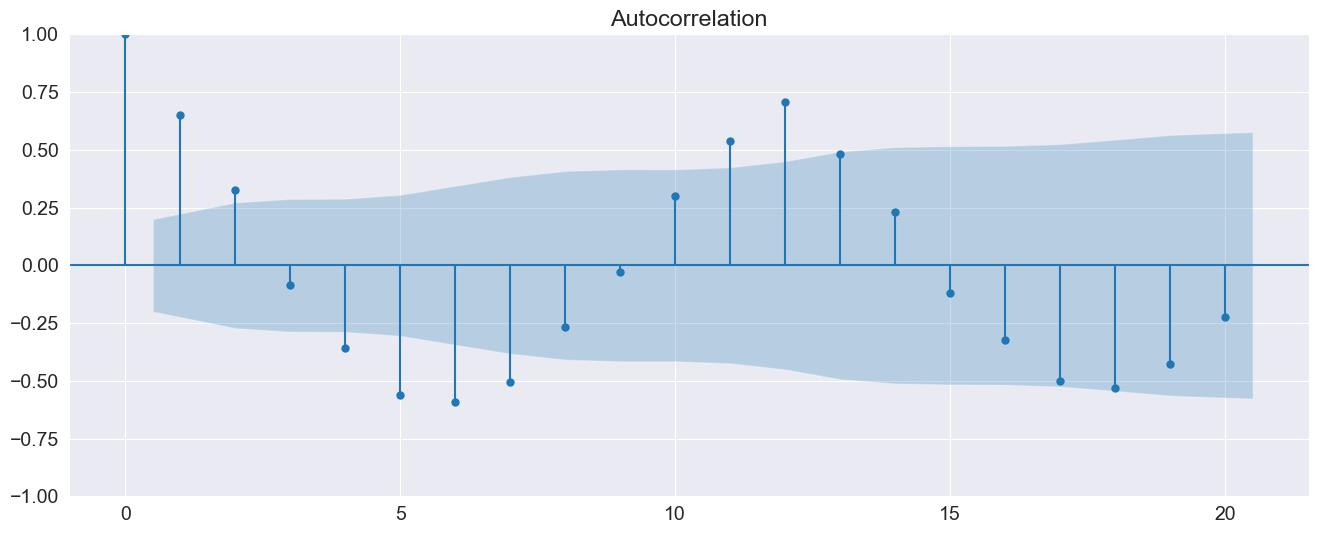

In [34]:
plot = plot_acf(cases)

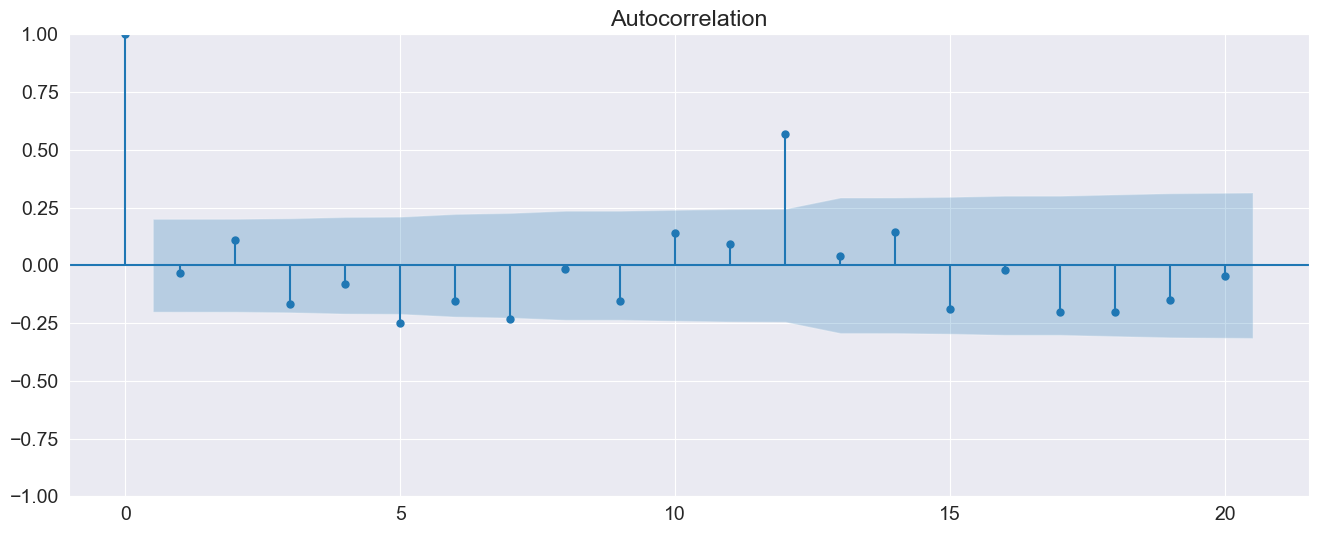

In [35]:
plot = plot_acf(difference(cases,1))

Indeed, there is a significant positive correlation between a value and the value 12 months prior. This makes sense - increasing flu incidence this time last year predicts the change in flu incidence right now. 

---

We can perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to test the null hypothesis that the ILI incidence trend is stationary. If we cannot reject the null hypothesis, we have further evidence that the data is stationary and we may use autocorrelation to model it.

In [36]:
from statsmodels.tsa.stattools import kpss

In [37]:
statistic, pvalue, lags, critical_values = kpss(cases, nlags=12)

print(f'KPSS Test Statistic: {statistic:.2f}')
print(f'p-value: {pvalue:.2f}')
print(f'Lags: {lags}')
for key, value in critical_values.items():
    print('Critial Values:')
    print(f'   {key}, {value:.2f}')

KPSS Test Statistic: 0.33
p-value: 0.10
Lags: 12
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74


With p-value = 0.10, we cannot reject the null hypothesis that the trend is stationary.

---

In [38]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

                            AutoReg Model Results                             
Dep. Variable:         reported_cases   No. Observations:                   96
Model:                    AutoReg(12)   Log Likelihood                -728.365
Method:               Conditional MLE   S.D. of innovations           1411.031
Date:                Thu, 26 Oct 2023   AIC                           1484.730
Time:                        16:41:29   BIC                           1518.762
Sample:                    01-01-2013   HQIC                          1498.411
                         - 12-01-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2169.3107   1203.860      1.802      0.072    -190.211    4528.833
reported_cases.L1      0.3044      0.097      3.146      0.002       0.115       0.494
reported_cases.L2   

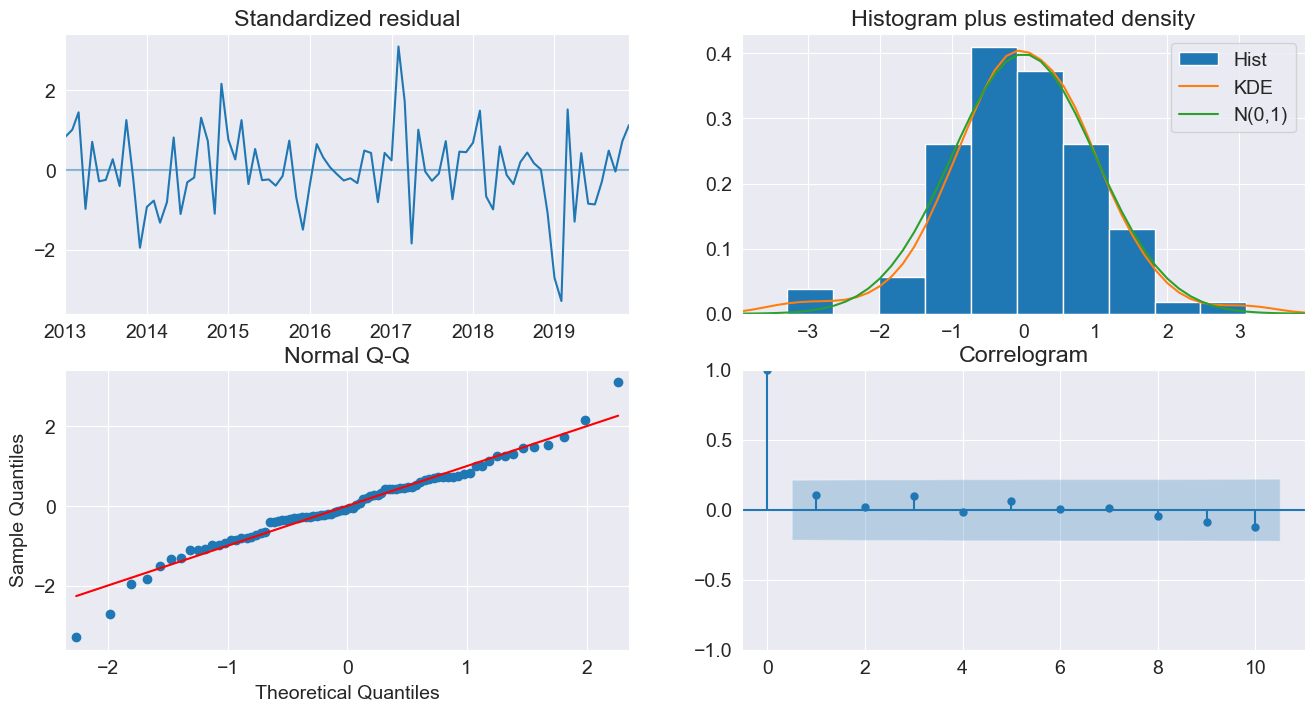

In [39]:
# Here we are creating an autoregression model with correlation terms
# for lags up to and including 12 months.

df_auto_reg = pd.DataFrame(df_before_2020.set_index('Date')['reported_cases'])


mod = AutoReg(df_auto_reg,12)
res = mod.fit()
print(res.summary())

df_auto_reg['predicted'] = res.predict()
p=px.line(df_auto_reg) 
plot = res.plot_diagnostics(figsize=(16,8))
p

We see that this autocorrelation model's predicted values do map well over actual values. Not all of the included terms are significant, however. Let's try using an autocorrelation variant that selects the most important terms and throws out the rest

                            AutoReg Model Results                             
Dep. Variable:         reported_cases   No. Observations:                   96
Model:             Restr. AutoReg(12)   Log Likelihood                -731.229
Method:               Conditional MLE   S.D. of innovations           1459.972
Date:                Thu, 26 Oct 2023   AIC                           1472.459
Time:                        16:41:31   BIC                           1484.613
Sample:                    01-01-2013   HQIC                          1477.345
                         - 12-01-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                810.7948    361.541      2.243      0.025     102.188    1519.401
reported_cases.L1      0.3339      0.082      4.080      0.000       0.173       0.494
reported_cases.L3   

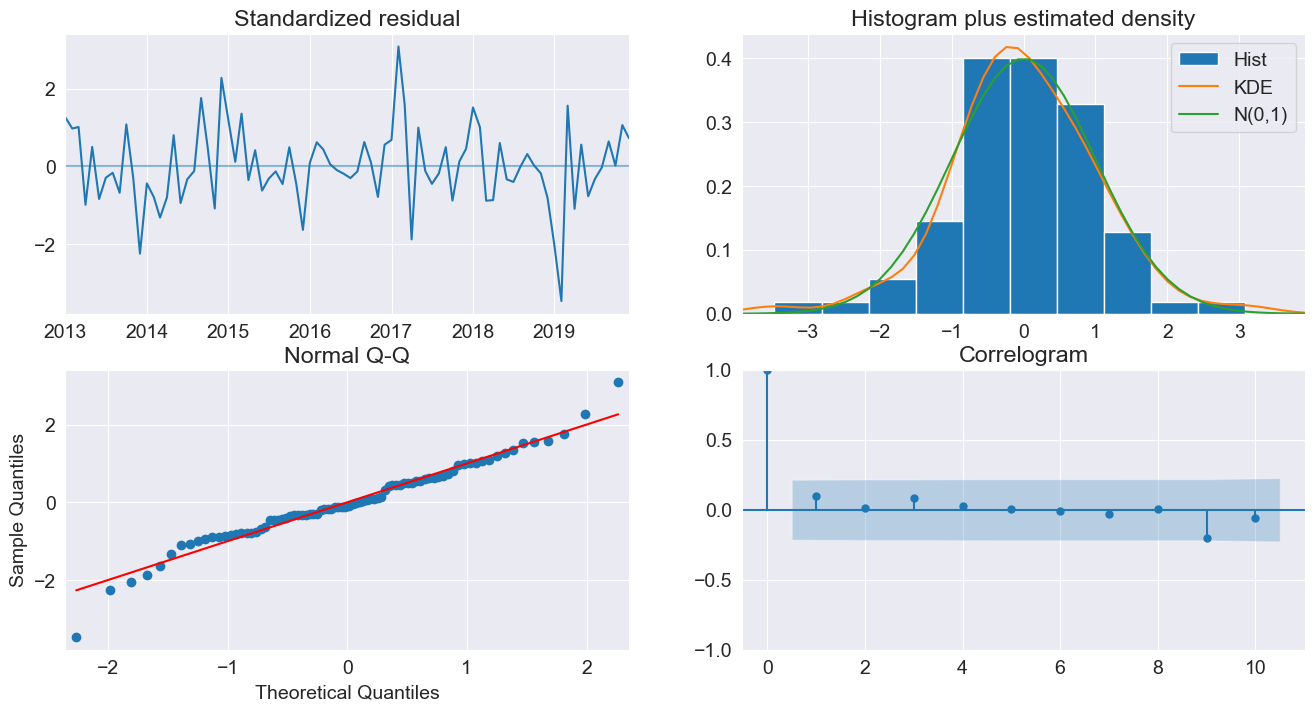

In [40]:
# Here we are creating an autocorrelation model with selected terms
# based on the best of 2^maxlags models

df_auto_reg = pd.DataFrame(df_before_2020.set_index('Date')['reported_cases'])

sel = ar_select_order(
    df_auto_reg
    , maxlag=12
    , glob=True
    )
sel.ar_lags
res = sel.model.fit()
print(res.summary())

df_auto_reg['predicted'] = res.predict()
p=px.line(df_auto_reg) 
plot = res.plot_diagnostics(figsize=(16,8))
p

The algorithm selected lags at 1, 3, and 12 months. This produced a model that performs slightly better than the model with includes all lags up to 12 months. 

---